# 4 Assets - Commodities, ETFs & Forex Simulation

This notebook simulates the rebalancing algorithim with a variety of stocks, forex and commodity assets.

In [1]:
%run logs.ipynb
%run models.ipynb
%run import_data.ipynb
%run preprocessing.ipynb
%run visualizations.ipynb

### Read data from various sources
Here we prepare our data from various sources. We take 4 different assets from various sources and buying power represented in USD terms.

Asset prices were downloaded from Quandl and saved in this repo as CSV files. Most we are taking the open prices.

In [2]:
# Read all the dataset with accurate data
raw_asset_aud_usd = read_perth_daily_data(asset_name='AUD/USD')
raw_asset_gld_usd = read_perth_daily_data(asset_name='GOLD/USD')
raw_asset_spy = read_yahoo_finance_daily_data(asset_name='SPY')
raw_asset_eur_usd = read_ecb_daily_data(asset_name='EUR/USD')
raw_asset_wbtc_usd = read_crypto_dialy_data(asset_name='WBTC/USD')
raw_asset_eth_usd = read_crypto_dialy_data(asset_name='ETH/USD')
raw_asset_btc_usd = read_crypto_dialy_data(asset_name='BTC/USD')
raw_asset_dai_usd = read_crypto_dialy_data(asset_name='DAI/USD')
raw_asset_usdc_usd = read_crypto_dialy_data(asset_name='USDC/USD')
raw_asset_tusd_usd = read_crypto_dialy_data(asset_name='TUSD/USD')

# Read all the data with price reversed
raw_asset_aud_usd_rev = read_perth_daily_data(asset_name='AUD/USD', reverse=True)
raw_asset_gld_usd_rev = read_perth_daily_data(asset_name='GOLD/USD', reverse=True)
raw_asset_spy_rev = read_yahoo_finance_daily_data(asset_name='SPY',  reverse=True)
raw_asset_eur_usd_rev = read_ecb_daily_data(asset_name='EUR/USD',  reverse=True)
raw_asset_wbtc_usd_rev = read_crypto_dialy_data(asset_name='WBTC/USD',  reverse=True)
raw_asset_eth_usd_rev = read_crypto_dialy_data(asset_name='ETH/USD',  reverse=True)
raw_asset_btc_usd_rev = read_crypto_dialy_data(asset_name='BTC/USD',  reverse=True)
raw_asset_dai_usd_rev = read_crypto_dialy_data(asset_name='DAI/USD',  reverse=True)
raw_asset_usdc_usd_rev = read_crypto_dialy_data(asset_name='USDC/USD',  reverse=True)
raw_asset_tusd_usd_rev = read_crypto_dialy_data(asset_name='TUSD/USD',  reverse=True)
raw_asset_gld_usd_rev = read_perth_daily_data(asset_name='GOLD/USD', reverse=True)

# Running the Simulation - 20 years of data

Here we try with data from 1990-2020 and keep 50% of the vault in GOLD and the remaining in Australian Dollar, Euro and SPY500 ETF. AUS and EUR will represent the fiat markets and SPY500 ETF will represent the stock market. Since usually gold is used as a hedge against the stock & forex markets, we keep a 50% ratio in gold.

We use the following parameters:

- Stop sell of 30%
- Stop loss of 30%
- 5% slippage for every rebalance
- Rebalance to happen once every 7 days
- 50% of the appreciated value from the appreciating asset, is sold off during every rebalance
- Starting with a buying power of 100 (so that it is easy to measure % increase)

And assets are distributed with the following ratios:

- Australian Dollar (25% starting buying power)
- Gold (25% starting buying power) 
- S&P 500 ETF (25% starting buying power)
- Euro (25% starting buying power)

### Results

At the end of the simulation, the vault has rebalanced itself around 90 times over the course of 20 years and is up by 309%.

### Simulation 1- with actual data

In [3]:
multiple_assets_raw_df = get_df_for_multiple_assets(
    raw_asset_eur_usd, #EUR/USD
    raw_asset_gld_usd, #GOLD/USD
    raw_asset_wbtc_usd, #WBTC/USD
    raw_asset_eth_usd #ETH/USD
).sort_values(by='Date').reset_index(drop=True)

# To give average price of the year.
df_info = multiple_assets_raw_df.groupby(multiple_assets_raw_df['Date'].dt.year).agg(['mean', 'max', 'min'])
df_info.columns = ["_".join(x) for x in df_info.columns.ravel()]
df_info.columns = ["_".join(x.split("_")[-2: ]) for x in df_info.columns]

df_info.head(df_info.shape[0])

EUR/USD_mean  EUR/USD_max  EUR/USD_min  GOLD/USD_mean  GOLD/USD_max  \
Date                                                                        
2019      1.117589       1.1488       1.0889    1399.330179       1543.71   
2020      1.117218       1.1940       1.0707    1707.676189       2058.12   

      GOLD/USD_min  WBTC/USD_mean  WBTC/USD_max  WBTC/USD_min  ETH/USD_mean  \
Date                                                                          
2019       1268.07    7696.205736  12510.267110   3395.978616    186.275761   
2020       1480.38    9043.446226  12299.789807   4946.043031    229.365443   

      ETH/USD_max  ETH/USD_min  
Date                            
2019   336.753188   104.535299  
2020   437.397840   110.605876

Finished with 6 rebalances
Final buying power of the vault is 184



EUR/USD   GOLD/USD   WBTC/USD    ETH/USD
Before buying pow.  50.000000  20.000000  20.000000  10.000000
Before #buy          0.000000   0.000000   0.000000   0.000000
Before #sell         0.000000   0.000000   0.000000   0.000000
Before held qty.    43.748359   0.015260   0.005720   0.091821
After buying pow.   54.653730  33.338753  68.378768  28.057862
After #buy          19.000000  19.000000  17.000000   2.000000
After #sell          0.000000   0.000000   2.000000  17.000000
After held qty.     45.773643   0.016977   0.005773   0.064489

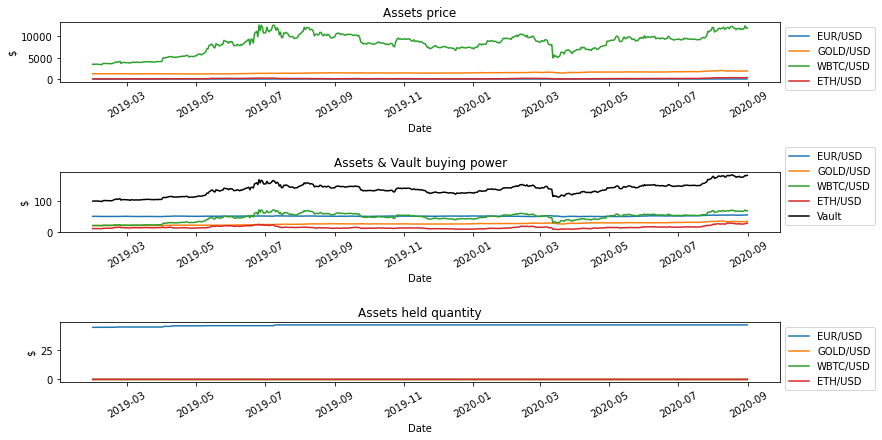

In [4]:
start_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-20 * 365, unit='D') 
end_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-0 * 365, unit='D')

multiple_assets_df = get_df_data_within_range(df=multiple_assets_raw_df, from_date=start_date, to_date=end_date)
multiple_assets_df_list = get_multiple_assets_df_list(multiple_assets_df)

simulation_logs, initial_vault, vault = simulate_multiple_assets_vault(
    multiple_assets_df_list,
    [0.5, 0.2, 0.2, 0.1],
    starting_buying_power=100,
    slippage=0.05,
    sell_apr_percentage=0.5,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

plot_multiple_assets_results(simulation_logs)

# Get no. of assets.
no_of_assets = simulation_logs['no_of_assets']

print_vault_before_after(no_of_assets, initial_vault, vault)

In [5]:
print_logs_in_tabular(simulation_logs)

EUR/USD_Buying_Pow.  EUR/USD_Held_Qty.  EUR/USD_Price  \
Date                                                                
2019-01-30            50.000000          43.748359         1.1429   
2019-01-31            50.258115          43.748359         1.1488   
2019-02-01            50.183743          43.748359         1.1471   
2019-02-02            50.183743          43.748359         1.1471   
2019-02-03            50.183743          43.748359         1.1471   
2019-02-04            50.069997          43.748359         1.1445   
2019-02-05            49.973751          43.748359         1.1423   
2019-02-06            49.846881          43.748359         1.1394   
2019-02-07            49.632514          43.748359         1.1345   
2019-02-08            49.636889          43.748359         1.1346   
2019-02-09            49.636889          43.748359         1.1346   
2019-02-10            49.636889          43.748359         1.1346   
2019-02-11            49.475020          43.748359         1.1309   
2019-02-12            49.418147          43.748359         1.1296   
2019-02-13            49.540386          43.821660         1.1305   
2019-02-14            49.378246          43.821660         1.1268   
2019-02-15            49.343189          43.821660         1.1260   
2019-02-16            49.343189          43.821660         1.1260   
2019-02-17            49.343189          43.821660         1.1260   
2019-02-18            49.641176          43.821660         1.1328   
2019-02-19            49.492183          43.821660         1.1294   
2019-02-20            49.943691          44.034290         1.1342   
2019-02-21            49.996533          44.034290         1.1354   
2019-02-22            49.868833          44.034290         1.1325   
2019-02-23            49.868833          44.034290         1.1325   
2019-02-24            49.868833          44.034290         1.1325   
2019-02-25            50.000936          44.034290         1.1355   
2019-02-26            50.027357          44.034290         1.1361   
2019-02-27            50.137442          44.034290         1.1386   
2019-02-28            50.269545          44.034290         1.1416   
2019-03-01            50.124232          44.034290         1.1383   
2019-03-02            50.124232          44.034290         1.1383   
2019-03-03            50.124232          44.034290         1.1383   
2019-03-04            49.921674          44.034290         1.1337   
2019-03-05            49.886447          44.034290         1.1329   
2019-03-06            49.780765          44.034290         1.1305   
2019-03-07            49.631048          44.034290         1.1271   
2019-03-08            49.415280          44.034290         1.1222   
2019-03-09            49.415280          44.034290         1.1222   
2019-03-10            49.415280          44.034290         1.1222   
2019-03-11            49.512155          44.034290         1.1244   
2019-03-12            49.648662          44.034290         1.1275   
2019-03-13            49.771958          44.034290         1.1303   
2019-03-14            49.736730          44.034290         1.1295   
2019-03-15            49.793975          44.034290         1.1308   
2019-03-16            49.793975          44.034290         1.1308   
2019-03-17            49.793975          44.034290         1.1308   
2019-03-18            49.974515          44.034290         1.1349   
2019-03-19            50.014146          44.034290         1.1358   
2019-03-20            49.996533          44.034290         1.1354   
2019-03-21            50.141846          44.034290         1.1387   
2019-03-22            49.767554          44.034290         1.1302   
2019-03-23            49.767554          44.034290         1.1302   
2019-03-24            49.767554          44.034290         1.1302   
2019-03-25            49.868833          44.034290         1.1325   
2019-03-26            49.719117          44.034290         1.1291   
2019-03-27

### More simulations: (TODO)

- Different assets
- Crypto only assets
- Appreciating and Depreciating Asset
- Depreciating and Deprectiaitng Asset

### Simulation 2-  with gold price reversed to treat it as a depreciating asset

In [6]:
multiple_assets_raw_df_2 = get_df_for_multiple_assets(
    raw_asset_eur_usd, # EUR/USD
    raw_asset_gld_usd_rev, # Rev of GOLD/USD
    raw_asset_aud_usd, # AUD/USD
    raw_asset_spy # SPY
).sort_values(by='Date').reset_index(drop=True)

# To give average price of the year.
df_info_2 = multiple_assets_raw_df_2.groupby(multiple_assets_raw_df_2['Date'].dt.year).agg(['mean', 'max', 'min'])
df_info_2.columns = ["_".join(x) for x in df_info_2.columns.ravel()]
df_info_2.columns = ["_".join(x.split("_")[1: ]) for x in df_info_2.columns]

df_info_2.head(df_info.shape[0])

EUR/USD_mean  EUR/USD_max  EUR/USD_min  GOLD/USD_Rev_mean  \
Date                                                              
1999      1.065557       1.1790       1.0015         889.065580   
2000      0.924088       1.0388       0.8252         851.844672   

      GOLD/USD_Rev_max  GOLD/USD_Rev_min  AUD/USD_mean  AUD/USD_max  \
Date                                                                  
1999           1099.48            708.16      0.645058       0.6720   
2000           1018.63            648.23      0.581938       0.6656   

      AUD/USD_min   SPY_mean     SPY_max    SPY_min  
Date                                                 
1999       0.6138  89.593655   99.538696  81.276733  
2000       0.5116  97.202984  104.335335  86.460693

Finished with 60 rebalances
Final buying power of the vault is 147



EUR/USD  GOLD/USD_Rev    AUD/USD        SPY
Before buying pow.  50.000000     20.000000  20.000000  10.000000
Before #buy          0.000000      0.000000   0.000000   0.000000
Before #sell         0.000000      0.000000   0.000000   0.000000
Before held qty.    56.908718      0.024443  37.292560   0.101582
After buying pow.   66.590696     26.656279  26.890688  27.810303
After #buy          59.000000     62.000000  27.000000  38.000000
After #sell          3.000000      0.000000  35.000000  24.000000
After held qty.     55.771102      0.072593  36.551160   0.079934

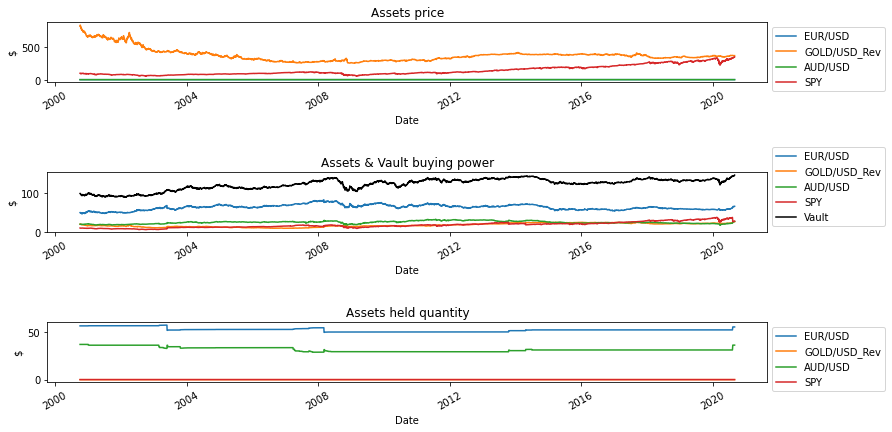

In [7]:
start_date_2 = pd.Timestamp('today').floor('D') + pd.Timedelta(-20 * 365, unit='D') 
end_date_2 = pd.Timestamp('today').floor('D') + pd.Timedelta(-0 * 365, unit='D')

multiple_assets_raw_df_2 = get_df_data_within_range(df=multiple_assets_raw_df_2,
                                                    from_date=start_date_2, to_date=end_date_2)

multiple_assets_df_2_list = get_multiple_assets_df_list(multiple_assets_raw_df_2)

simulation_logs_2, initial_vault_2, vault_2 = simulate_multiple_assets_vault(
    multiple_assets_df_2_list,
    [0.5, 0.2, 0.2, 0.1],
    starting_buying_power=100,
    slippage=0.05,
    sell_apr_percentage=0.5,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

plot_multiple_assets_results(simulation_logs_2)

# Get no. of assets.
no_of_assets_2 = simulation_logs_2['no_of_assets']

print_vault_before_after(no_of_assets_2, initial_vault_2, vault_2)

In [8]:
print_logs_in_tabular(simulation_logs_2)

EUR/USD_Buying_Pow.  EUR/USD_Held_Qty.  EUR/USD_Price  \
Date                                                                
2000-10-05            50.000000          56.908718         0.8786   
2000-10-06            49.527658          56.908718         0.8703   
2000-10-07            49.527658          56.908718         0.8703   
2000-10-08            49.527658          56.908718         0.8703   
2000-10-09            49.482131          56.908718         0.8695   
2000-10-10            49.630093          56.908718         0.8721   
2000-10-11            49.624402          56.908718         0.8720   
2000-10-12            49.214660          56.908718         0.8648   
2000-10-13            49.095151          56.908718         0.8627   
2000-10-14            49.095151          56.908718         0.8627   
2000-10-15            49.095151          56.908718         0.8627   
2000-10-16            48.435010          56.908718         0.8511   
2000-10-17            48.349647          56.908718         0.8496   
2000-10-18            48.514682          56.908718         0.8525   
2000-10-19            47.865923          56.908718         0.8411   
2000-10-20            48.099249          56.908718         0.8452   
2000-10-21            48.099249          56.908718         0.8452   
2000-10-22            48.099249          56.908718         0.8452   
2000-10-23            47.672433          56.908718         0.8377   
2000-10-24            47.723651          56.908718         0.8386   
2000-10-25            47.274072          56.908718         0.8307   
2000-10-26            46.961074          56.908718         0.8252   
2000-10-27            47.370817          56.908718         0.8324   
2000-10-28            47.370817          56.908718         0.8324   
2000-10-29            47.370817          56.908718         0.8324   
2000-10-30            48.269975          56.908718         0.8482   
2000-10-31            47.900068          56.908718         0.8417   
2000-11-01            48.679718          56.908718         0.8554   
2000-11-02            49.203278          56.908718         0.8646   
2000-11-03            49.681311          56.908718         0.8730   
2000-11-04            49.681311          56.908718         0.8730   
2000-11-05            49.681311          56.908718         0.8730   
2000-11-06            49.322786          56.908718         0.8667   
2000-11-07            48.867517          56.908718         0.8587   
2000-11-08            48.708172          56.908718         0.8559   
2000-11-09            48.548828          56.908718         0.8531   
2000-11-10            49.356931          56.908718         0.8673   
2000-11-11            49.356931          56.908718         0.8673   
2000-11-12            49.356931          56.908718         0.8673   
2000-11-13            49.055315          56.908718         0.8620   
2000-11-14            48.844753          56.908718         0.8583   
2000-11-15            48.918734          56.908718         0.8596   
2000-11-16            48.765081          56.908718         0.8569   
2000-11-17            48.571591          56.908718         0.8535   
2000-11-18            48.571591          56.908718         0.8535   
2000-11-19            48.571591          56.908718         0.8535   
2000-11-20            48.304120          56.908718         0.8488   
2000-11-21            48.224448          56.908718         0.8474   
2000-11-22            47.968359          56.908718         0.8429   
2000-11-23            47.956977          56.908718         0.8427   
2000-11-24            48.008195          56.908718         0.8436   
2000-11-25            48.008195          56.908718         0.8436   
2000-11-26            48.008195          56.908718         0.8436   
2000-11-27            47.837469          56.908718         0.8406   
2000-11-28            48.719554          56.908718         0.8561   
2000-11-29            49.226041          56.908718         0.8650   
2000-11-30

### Simulation 3- with assets, both depreciating

In [9]:
# You can use other <other_assets_df.copy> in case you want different dates.
# Have used ....copy() on df because this will automatically provide the req dates and points,
# only have to change the price column this way.
depreciating_asset = raw_asset_wbtc_usd_rev.copy()
depreciating_asset.iloc[:, 1] = np.arange(100, 100 + depreciating_asset.shape[0])[::-1]
depreciating_asset.columns = ['Date', 'Price_Depreciating_Asset']

multiple_assets_raw_df_3 = get_df_for_multiple_assets(
    raw_asset_gld_usd_rev, # Rev of GOLD/USD
    depreciating_asset, # Artifical Depreciating asset
).sort_values(by='Date').reset_index(drop=True)

# To give average price of the year.
df_info_3 = multiple_assets_raw_df_3.groupby(multiple_assets_raw_df_3['Date'].dt.year).agg(['mean', 'max', 'min'])
df_info_3.columns = ["_".join(x) for x in df_info_3.columns.ravel()]
df_info_3.columns = ["_".join(x.split("_")[1: ]) for x in df_info_3.columns]

df_info_3.head(df_info.shape[0])

GOLD/USD_Rev_mean  GOLD/USD_Rev_max  GOLD/USD_Rev_min  \
Date                                                          
2019          347.24875            368.03            334.68   
2020          359.50250            370.90            343.73   

      Depreciating_Asset_mean  Depreciating_Asset_max  Depreciating_Asset_min  
Date                                                                           
2019                    511.5                   679.0                   344.0  
2020                    221.5                   343.0                   100.0

Finished with 1 rebalances
Final buying power of the vault is 59



GOLD/USD_Rev  Depreciating_Asset
Before buying pow.     50.000000           50.000000
Before #buy             0.000000            0.000000
Before #sell            0.000000            0.000000
Before held qty.        0.143152            0.073638
After buying pow.      52.149107            7.424081
After #buy              0.000000            1.000000
After #sell             1.000000            0.000000
After held qty.         0.142018            0.074241

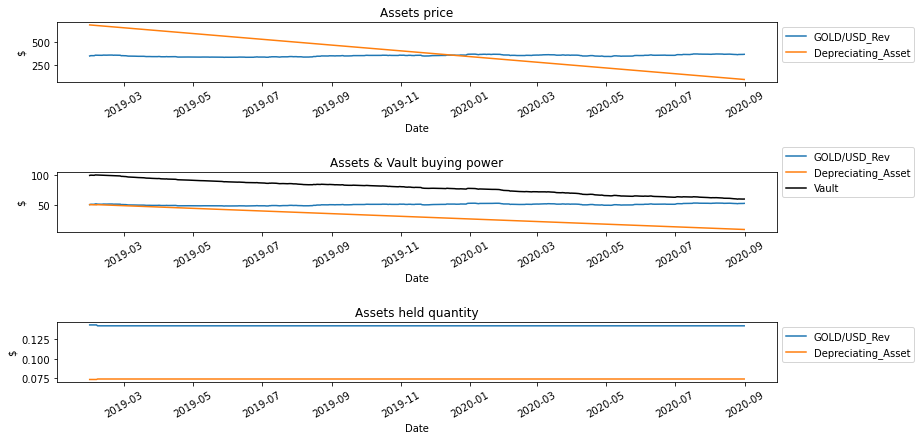

In [10]:
start_date_3 = pd.Timestamp('today').floor('D') + pd.Timedelta(-20 * 365, unit='D') 
end_date_3 = pd.Timestamp('today').floor('D') + pd.Timedelta(-0 * 365, unit='D')

multiple_assets_raw_df_3 = get_df_data_within_range(df=multiple_assets_raw_df_3,
                                                    from_date=start_date_3, to_date=end_date_3)

multiple_assets_df_3_list = get_multiple_assets_df_list(multiple_assets_raw_df_3)

simulation_logs_3, initial_vault_3, vault_3 = simulate_multiple_assets_vault(
    multiple_assets_df_3_list,
    [0.5, 0.5],
    starting_buying_power=100,
    slippage=0.05,
    sell_apr_percentage=0.5,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

plot_multiple_assets_results(simulation_logs_3)

# Get no. of assets.
no_of_assets_3 = simulation_logs_3['no_of_assets']

print_vault_before_after(no_of_assets_3, initial_vault_3, vault_3)

In [11]:
print_logs_in_tabular(simulation_logs_3)

GOLD/USD_Rev_Buying_Pow.  GOLD/USD_Rev_Held_Qty.  \
Date                                                           
2019-01-30                 50.000000                0.143152   
2019-01-31                 50.536819                0.143152   
2019-02-01                 50.489579                0.143152   
2019-02-02                 50.489579                0.143152   
2019-02-03                 50.489579                0.143152   
2019-02-04                 51.219652                0.143152   
2019-02-05                 51.219652                0.143152   
2019-02-06                 50.785731                0.142018   
2019-02-07                 50.697680                0.142018   
2019-02-08                 50.636612                0.142018   
2019-02-09                 50.636612                0.142018   
2019-02-10                 50.636612                0.142018   
2019-02-11                 50.949052                0.142018   
2019-02-12                 50.893665                0.142018   
2019-02-13                 50.842539                0.142018   
2019-02-14                 50.842539                0.142018   
2019-02-15                 50.977456                0.142018   
2019-02-16                 50.977456                0.142018   
2019-02-17                 50.977456                0.142018   
2019-02-18                 50.842539                0.142018   
2019-02-19                 51.010120                0.142018   
2019-02-20                 50.728924                0.142018   
2019-02-21                 50.863841                0.142018   
2019-02-22                 50.825496                0.142018   
2019-02-23                 50.825496                0.142018   
2019-02-24                 50.825496                0.142018   
2019-02-25                 50.825496                0.142018   
2019-02-26                 50.700520                0.142018   
2019-02-27                 50.033034                0.142018   
2019-02-28                 50.146649                0.142018   
2019-03-01                 49.983328                0.142018   
2019-03-02                 49.983328                0.142018   
2019-03-03                 49.983328                0.142018   
2019-03-04                 49.653846                0.142018   
2019-03-05                 49.450760                0.142018   
2019-03-06                 49.450760                0.142018   
2019-03-07                 49.450760                0.142018   
2019-03-08                 49.504726                0.142018   
2019-03-09                 49.504726                0.142018   
2019-03-10                 49.504726                0.142018   
2019-03-11                 49.301640                0.142018   
2019-03-12                 49.205068                0.142018   
2019-03-13                 49.180925                0.142018   
2019-03-14                 49.138319                0.142018   
2019-03-15                 49.138319                0.142018   
2019-03-16                 49.138319                0.142018   
2019-03-17                 49.138319                0.142018   
2019-03-18                 49.138319                0.142018   
2019-03-19                 49.121277                0.142018   
2019-03-20                 48.861384                0.142018   
2019-03-21                 48.733567                0.142018   
2019-03-22                 48.783274                0.142018   
2019-03-23                 48.783274                0.142018   
2019-03-24                 48.783274                0.142018   
2019-03-25                 48.659718                0.142018   
2019-03-26                 48.659718                0.142018   
2019-03-27                 48.619953                0.142018   
2019-03-28                 48.705164                0.142018   
2019-03-29                 48.648356                0.142018   
2019-03-30                 48.648356                0.142018   
2019-03-31                 48.648356        

### Simulation 4-  with 1 asset appreciating and other fluctuating

In [12]:
# You can use other <other_assets_df.copy> in case you want different dates.
# Have used ....copy() on df because this will automatically provide the req dates and points,
# only have to change the price column this way.
sin_wave_asset = raw_asset_wbtc_usd_rev.copy()

sin_wave_asset.iloc[:, 1] = np.linspace(0.0, 10.0, sin_wave_asset.shape[0])
sin_wave_asset.iloc[:, 1] = np.sin(sin_wave_asset.iloc[:, 1]) + abs(np.min(sin_wave_asset.iloc[:, 1]))

sin_wave_asset_min = np.min(sin_wave_asset.iloc[:, 1])
sin_wave_asset_max = np.max(sin_wave_asset.iloc[:, 1])

range_start = 0.4 # take value lower than the lower bound.
range_start = 1.6 # take value upper than the upper bound.

sin_wave_asset.iloc[:, 1] = (
    (1.6 - 0.4) * (
        (sin_wave_asset.iloc[:, 1] - sin_wave_asset_min) / (sin_wave_asset_max - sin_wave_asset_min)
    ) + 0.4
)

sin_wave_asset.columns = ['Date', 'Price_Sin_Asset']

multiple_assets_raw_df_4 = get_df_for_multiple_assets(
    raw_asset_eur_usd, # EUR/USD
    sin_wave_asset # Sine wave asset
).sort_values(by='Date').reset_index(drop=True)

# To give average price of the year.
df_info_4 = multiple_assets_raw_df_4.groupby(multiple_assets_raw_df_4['Date'].dt.year).agg(['mean', 'max', 'min'])
df_info_4.columns = ["_".join(x) for x in df_info_4.columns.ravel()]
df_info_4.columns = ["_".join(x.split("_")[1: ]) for x in df_info_4.columns]

df_info_4.head(df_info.shape[0])

EUR/USD_mean  EUR/USD_max  EUR/USD_min  Sin_Asset_mean  Sin_Asset_max  \
Date                                                                          
2019      1.117589       1.1488       1.0889        1.012099       1.600000   
2020      1.117218       1.1940       1.0707        1.244504       1.599994   

      Sin_Asset_min  
Date                 
2019       0.400000  
2020       0.673586

Finished with 13 rebalances
Final buying power of the vault is 93



EUR/USD  Sin_Asset
Before buying pow.  50.000000  50.000000
Before #buy          0.000000   0.000000
Before #sell         0.000000   0.000000
Before held qty.    43.748359  50.000046
After buying pow.   66.859967  26.743331
After #buy          13.000000   0.000000
After #sell          0.000000  13.000000
After held qty.     55.996622  39.702932

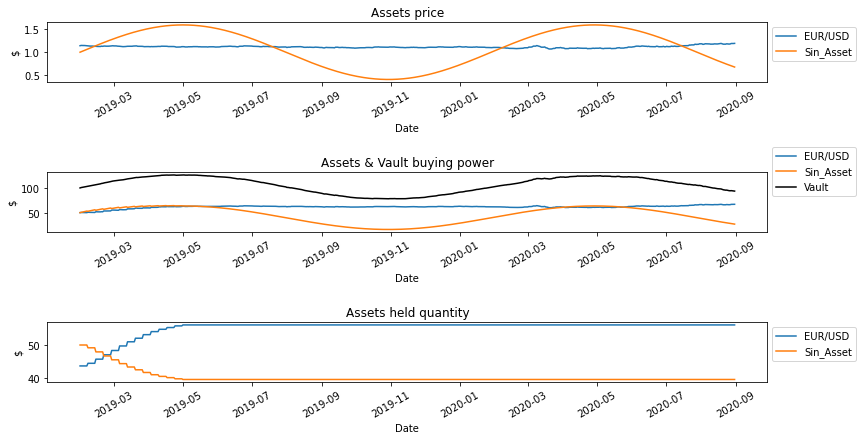

In [13]:
start_date_4 = pd.Timestamp('today').floor('D') + pd.Timedelta(-20 * 365, unit='D') 
end_date_4 = pd.Timestamp('today').floor('D') + pd.Timedelta(-0 * 365, unit='D')

multiple_assets_raw_df_4 = get_df_data_within_range(df=multiple_assets_raw_df_4,
                                                    from_date=start_date_4, to_date=end_date_4)

multiple_assets_df_4_list = get_multiple_assets_df_list(multiple_assets_raw_df_4)

simulation_logs_4, initial_vault_4, vault_4 = simulate_multiple_assets_vault(
    multiple_assets_df_4_list,
    [0.5, 0.5],
    starting_buying_power=100,
    slippage=0.05,
    sell_apr_percentage=0.5,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

plot_multiple_assets_results(simulation_logs_4)

# Get no. of assets.
no_of_assets_4 = simulation_logs_4['no_of_assets']

print_vault_before_after(no_of_assets_4, initial_vault_4, vault_4)

In [ ]:
print_logs_in_tabular(simulation_logs_4)

EUR/USD_Buying_Pow.  EUR/USD_Held_Qty.  EUR/USD_Price  \
Date                                                                
2019-01-30            50.000000          43.748359         1.1429   
2019-01-31            50.258115          43.748359         1.1488   
2019-02-01            50.183743          43.748359         1.1471   
2019-02-02            50.183743          43.748359         1.1471   
2019-02-03            50.183743          43.748359         1.1471   
2019-02-04            50.069997          43.748359         1.1445   
2019-02-05            49.973751          43.748359         1.1423   
2019-02-06            50.742551          44.534449         1.1394   
2019-02-07            50.524332          44.534449         1.1345   
2019-02-08            50.528786          44.534449         1.1346   
2019-02-09            50.528786          44.534449         1.1346   
2019-02-10            50.528786          44.534449         1.1346   
2019-02-11            50.364008          44.534449         1.1309   
2019-02-12            50.306114          44.534449         1.1296   
2019-02-13            51.743171          45.770165         1.1305   
2019-02-14            51.573822          45.770165         1.1268   
2019-02-15            51.537206          45.770165         1.1260   
2019-02-16            51.537206          45.770165         1.1260   
2019-02-17            51.537206          45.770165         1.1260   
2019-02-18            51.848443          45.770165         1.1328   
2019-02-19            51.692824          45.770165         1.1294   
2019-02-20            53.393761          47.076142         1.1342   
2019-02-21            53.450252          47.076142         1.1354   
2019-02-22            53.313731          47.076142         1.1325   
2019-02-23            53.313731          47.076142         1.1325   
2019-02-24            53.313731          47.076142         1.1325   
2019-02-25            53.454960          47.076142         1.1355   
2019-02-26            53.483205          47.076142         1.1361   
2019-02-27            55.062841          48.360127         1.1386   
2019-02-28            55.207921          48.360127         1.1416   
2019-03-01            55.048333          48.360127         1.1383   
2019-03-02            55.048333          48.360127         1.1383   
2019-03-03            55.048333          48.360127         1.1383   
2019-03-04            54.825876          48.360127         1.1337   
2019-03-05            54.787188          48.360127         1.1329   
2019-03-06            56.203135          49.715290         1.1305   
2019-03-07            56.034103          49.715290         1.1271   
2019-03-08            55.790498          49.715290         1.1222   
2019-03-09            55.790498          49.715290         1.1222   
2019-03-10            55.790498          49.715290         1.1222   
2019-03-11            55.899872          49.715290         1.1244   
2019-03-12            56.053989          49.715290         1.1275   
2019-03-13            57.601948          50.961646         1.1303   
2019-03-14            57.561179          50.961646         1.1295   
2019-03-15            57.627429          50.961646         1.1308   
2019-03-16            57.627429          50.961646         1.1308   
2019-03-17            57.627429          50.961646         1.1308   
2019-03-18            57.836372          50.961646         1.1349   
2019-03-19            57.882237          50.961646         1.1358   
2019-03-20            59.068221          52.024151         1.1354   
2019-03-21            59.239900          52.024151         1.1387   
2019-03-22            58.797695          52.024151         1.1302   
2019-03-23            58.797695          52.024151         1.1302   
2019-03-24            58.797695          52.024151         1.1302   
2019-03-25            58.917351          52.024151         1.1325   
2019-03-26            58.740469          52.024151         1.1291   
2019-03-27